<a href="https://colab.research.google.com/github/maxsolomonhenry/features_extractor/blob/master/respiratory_audio_sorting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Preliminaries**

Mount Google drive containing raw data.

Prepare and import dependencies.

In [0]:
#   Mounting google drive, downloading dataset, linking to pre-downloaded 
#   libraries and model weights.

import os, sys
from google.colab import drive, files
redownload = False

drive.mount('/content/gdrive', force_remount=True)
nb_path = '/content/gdrive/My Drive/Colab Notebooks/'
yamnet_path = '/content/gdrive/My Drive/Colab Notebooks/models/research/audioset/yamnet/'
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!pip install librosa --upgrade


if redownload:
  !kaggle datasets download -d vbookshelf/respiratory-sound-database
  !unzip \*.zip  && rm *.zip

if (nb_path and yamnet_path) not in sys.path:
    sys.path.append(yamnet_path)
    sys.path.insert(0, nb_path)

if 'heartpy' not in sys.modules:
    !pip install heartpy

# Load dependencies.

import numpy as np 
import pandas as pd
import librosa
import librosa.display
import resampy
import sklearn
import time
import pickle
import pywt
import heartpy
import scipy.signal
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model 
from IPython.display import Audio, display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.multiclass import OneVsRestClassifier
from tqdm.auto import tqdm
tqdm.pandas()

# Python scripts from google drive:
import yamnet as yamnet_model
import params

# **FeatureExtractor**

Definition of FeatureExtractor class.

In [0]:
class FeaturesExtractor:
    """Constructs a database of audio features for respiratory auscultation.

    Extracts time-invariant MIR features from a list of files, as they are
    specified in a pandas dataframe under the column ['filename']. The features
    are standardized, assuming a normal distribution. After calculation, data are
    appended to the appropriate rows (which may include, e.g., label information
    for supervised learning). Current implementation allows for specifying extract
    start and stop times, potentially augmenting the size of the dataset.
    
    To extract features use the self.extract() method.

    Arguments:
    filenames_labels    --  a pandas dataframe containing at least one column
                            called 'filenames'
    audio_dir           --  a string specifying the directory with audio files.

    Outputs:
    self.feature_data   --  pandas dataframe with 'filenames' column replaced
                            by multiple columns of feature data.

    """

    def __init__(self, filenames_labels, audio_dir, do_gini_filter=False, 
                 do_spline_interp=False, resample_freq=16000):
        self.filenames_labels = filenames_labels.reset_index()
        self.audio_dir = audio_dir
        self.do_gini_filter = do_gini_filter
        self.do_spline_interp = do_spline_interp
        self.resample_freq = resample_freq
        self.fill_na=True
        self.filename = str()
        self.last_filename = str()
        self.t_start = str()
        self.t_stop = str()
        self.untrimmed_x = np.array([])
        self.x = np.array([])
        self.sr = int()
        self.feature_data = []
        self.yamnet_embed_model = Model()
        self.MODEL_PATH = ("/content/gdrive/My Drive/Colab Notebooks/models/"
                           "research/audioset/yamnet/yamnet.h5")
        self.EPS = 1e-12

    @staticmethod
    def get_safe_divisor(std_):
        std_[std_==0] = std_[std_==0] + 1
        return std_

    @staticmethod
    def verify_sr(x, sr):
        if sr is not params.SAMPLE_RATE:
            x = resampy.resample(x, sr, params.SAMPLE_RATE)
        return x

    @staticmethod
    def get_framed(x, frame_length):
        x_pad = np.pad(x, int(frame_length // 2), mode='edge')
        return librosa.util.frame(x_pad, frame_length, int(frame_length // 4))

    @staticmethod
    def get_bandpass(low_f, high_f, x, sr):
        nyquist = int(sr/2)      
        b, a = scipy.signal.butter(6, [low_f/nyquist, high_f/nyquist], 
                                   btype='bandpass')
        return scipy.signal.lfilter(b, a, x)

    def get_gini_index(self, array_):
        array_ = np.sort(array_) + self.EPS
        i = np.arange(0, array_.shape[0]) + 1
        N = array_.shape[0]
        return 1 - 2 * np.sum(np.abs(array_) * (N - i + 0.5)/N) / np.sum(array_)

    def get_short_time_energy(self, x, frame_length):
        framed = self.get_framed(x, frame_length=frame_length)
        return np.sum(framed**2, axis=0)

    def standardize(self, data):
        std_ = self.get_safe_divisor(data.std(axis=0))
        return (data - data.mean(axis=0))/std_

    def initialize_yamnet(self):
        yamnet = yamnet_model.yamnet_frames_model(params)
        yamnet.load_weights(self.MODEL_PATH)
        inp = yamnet.input
        out = yamnet.layers[-3].output
        self.yamnet_model = Model(inp, out)

    def get_x_index(self):
        i_start = int(self.t_start * self.sr)
        i_stop = int(self.t_stop * self.sr)
        return i_start, i_stop

    def set_x(self):
        if self.filename is not self.last_filename:
            filepath = os.path.join(self.audio_dir, self.filename)
            self.untrimmed_x, self.sr = librosa.load(filepath)

        if self.t_start:
            i_start, i_stop = self.get_x_index()
            self.x = self.untrimmed_x[i_start:i_stop]
        else:
            self.x = self.untrimmed_x[:]

        self.x /= np.max(self.x)
        self.last_filename = self.filename[:]
        self.clean_x()

    def clean_x(self):
        if self.resample_freq is not None:
            self.set_sr_and_filter()
        if self.do_gini_filter:
            self.gini_filter_x()
        if self.do_spline_interp:
            self.spline_interp_x()

    def set_sr_and_filter(self, low_f=150):
        """Bandpass filter and resampling audio file.

        Traditional auscultation sounds are lowpass in nature due to the dampening
        of high frequencies by the chest wall, so frequencies above 2 kHz can be
        safely attenuated. Bands below 150 Hz tend to be contaminated by heart-beat 
        sounds, and this range is also typically filtered out. Lowpass filtering
        permits resampling at a lower sample rate which saves on computational
        cost.

        Pramono, Renard Xaviero Adhi, Syed Anas Imtiaz, and Esther Rodriguez-Villegas. 
        2019. “Evaluation of features for classification of wheezes and normal 
        respiratory sounds.” PLOS One 14 (3): 21. https://doi.org/10.1371
        /journal.pone.0213659.



        """

        y = self.get_bandpass(low_f, self.resample_freq//4, self.x, self.sr)
        self.x = resampy.resample(y, self.sr, self.resample_freq)
        self.x /= np.max(self.x)
        self.sr = self.resample_freq

    def gini_filter_x(self, n_components=80):
        """Gini index median filtering for isolating tonal components.

        This cleaning operation is the first step in a chain of signal processing
        techniques used by Torre-Cruz et al. to isolate wheeze components of a
        respiratory signal. Columns representing tonal spectra in NMF factorization
        are thought to be more sparse, and hence to have a higher Gini index.

        Torre-Cruz, J., F. Canadas-Quesada, S. García-Galán, N. Ruiz-Reyes, 
            P. Vera-Candeas, and J. Carabias-Orti. 2020. “A constrained tonal semi-
            supervised non-negative matrix factorization to classify presence/
            absence of wheezing in respiratory rounds.” Applied Acoustics 161: 13. 
            https://doi.org/10.1016/j.apacoust.2019.107188.

        """

        stft_ = librosa.stft(self.x)
        spectrogram = np.abs(stft_)
        ginis_ = np.zeros(n_components)

        # NMF factorization.
        components, activations = \
            librosa.decompose.decompose(spectrogram, n_components=n_components)

        for i in range(n_components):
            ginis_[i] += self.get_gini_index(components[:, i])

        tonal_idxs = np.where(ginis_ > np.median(ginis_))[0]
        S = np.zeros(stft_.shape)

        for i in tonal_idxs:
            S += np.outer(components[:, i], activations[i, :])

        self.x = librosa.core.griffinlim(S)
        self.x /= np.max(self.x)

    def spline_interp_x(self):
        """Cubic spline interpolation of clipped signals.

        Emmanouilidou et al. (2018) propose a chain of cleaning techniques for
        noisy respiratory signals. Chief among them is cubic spline interpolation,
        meant to compensate for truncated waveforms as a result of clipping dis-
        tortion.

        Emmanouilidou, Dimitra, Eric D. McCollum, Daniel E. Park, and Mounya 
        Elhilali. 2018. “Computerized lung sound screening for pediatric 
        auscultation in noisy field environments.” IEEE Transactions on Biomedical 
        Engineering 65 (7): 1564–74. https://doi.org/10.1109/TBME.2017.2717280.


        """

        y = heartpy.preprocessing.interpolate_clipping(self.x, self.sr, threshold=1)
        y = heartpy.preprocessing.interpolate_clipping(-y, self.sr, threshold=1)
        y /= np.max(y)
        self.x = -y

    def get_framewise_entropy(self, stft_):
        power_spec = np.abs(stft_**2)
        distribution = power_spec/np.sum(power_spec, axis=0)
        spec_entropy = -np.diagonal(np.dot(distribution.T, np.log2(distribution)))
        return spec_entropy / np.log2(stft_.shape[0] + self.EPS)

    def get_mfccs(self):
        """Mel-frequency cepstral coefficients are commonly used in auscultation.

        Pramono, Renard, Stuart Bowyer, and Esther Rodriguez-Villegas. 2017. 
            “Automatic adventitious respiratory sound analysis: A systematic 
            review.” Edited by Thomas Penzel. PLOS One 12 (5). doi:10.1371
            /journal.pone.0177926.

        """

        mfccs = librosa.feature.mfcc(self.x, self.sr, n_mfcc=13)
        means = mfccs.mean(axis=1)
        stds = mfccs.std(axis=1)
        return np.hstack([means, stds])

    def get_chromagram(self):
        """ Chromagram peak as selected by regularization in Mendes et al. (2016).

        Mendes, L., I. M. Vogiatzis, E. Perantoni, E. Kaimakamis, I. Chouvarda, 
            N. Maglaveras, J. Henriques, P. Carvalho, and R. P. Paiva. 2016. 
            “Detection of crackle events using a multi-feature approach.” In 38th 
            Annual International Conference of the IEEE Engineering in Medicine 
            and Biology Society, 3679–3683.

        """

        chroma = librosa.feature.chroma_cqt(self.x, self.sr)
        peak = chroma.argmax(axis=0).mean()
        return np.hstack([peak])

    def get_yamnet_embeds(self):
        """A pre-trained deep neural network trained on the Audioset-Youtube corpus. 

        The last 512-neuron layer, which was especially designed for a Youtube
        categorization task, has been removed to reveal a 1024 neuron embeddings
        layer. Embeddings are calculated by YAMNet per frame, as per its intention
        of real-time categorization. Here, embeddings are averaged and collected 
        along with their standard deviations.

        Plakal, Manoj and Dan Ellis. 2020. "YAMNet." GitHub repository. 
            https://github.com/tensorflow/models/tree/master/research/audioset/yamnet

        """

        x = self.verify_sr(self.x, self.sr)
        embeddings = self.yamnet_model(np.reshape(x, [1, -1]))
        means = np.mean(embeddings, axis=0)
        stds = np.std(embeddings, axis=0)
        return np.hstack([means, stds])

    def get_voiced_score(self, frame_length=2048):
        """Rough estimation of voiced/unvoiced frame. Loosely based on:

        Bachu, R. G., S. Kopparthi, B. Adapa, and Buket D. Barkana. 2010. "Voiced/
            unvoiced decision for speech signals based on zero-crossing rate and
            energy." In Advanced Techniques in Computing Sciences and Software 
            Engineering, 279-282.

        """

        zero_cross = librosa.feature.zero_crossing_rate(self.x, frame_length=frame_length)
        st_energy = self.get_short_time_energy(self.x, frame_length=frame_length)
        voiced_score = np.ravel(st_energy/zero_cross)
        voiced_score = np.nan_to_num(voiced_score, nan=0, posinf=0)
        return np.hstack([voiced_score.mean(), voiced_score.std(), voiced_score.max()])

    def get_spectral_rolloffs(self):
        """Spectral rolloffs for wheeze and crackle detection.

        As selected by regularization methods in Mendes et al. (2016), see above,
        and in:

        Mendes, L., I. M. Vogiatzis, E. Perantoni, E. Kaimakamis, I. Chouvarda, 
            N. Maglaveras, V. Tsara, et al. 2015. “Detection of wheezes using their 
            signature in the spectrogram space and musical features.” In 37th Annual
            International Conference of the IEEE Engineering in Medicine and 
            Biology Society, 5581–5584.

        """

        roll75 = librosa.feature.spectral_rolloff(self.x, self.sr, roll_percent=0.75)
        roll95 = librosa.feature.spectral_rolloff(self.x, self.sr, roll_percent=0.95)
        return np.hstack([roll75.mean(), roll75.std(), roll95.mean(), roll95.std()])

    def get_spectral_moments(self):
        """Retrieve spectral mean, standard deviation, skew and kurtosis.

        In an effort to avoid redundancy with other spectral measurements, and
        with a nod to traditional MIR features in machine learning, these are
        calculated on the whole signal, i.e., on unframed data.

        Fujinaga, Ichiro. 1998. “Machine recognition of timbre using steady-state 
            tone of acoustic musical instruments.” In Proceedings of the 
            International Computer Music Conference, 4.

        """

        fft_ = np.fft.fft(self.x)
        hfft = len(fft_) // 2
        pos_fft_ = np.abs(fft_[:hfft])
        f = np.arange(hfft)

        centroid = np.dot(f, pos_fft_)
        var = np.dot(f**2, pos_fft_)
        skew = np.dot(f**3, pos_fft_)
        kurt = np.dot(f**4, pos_fft_)
        return np.hstack([centroid, var, skew, kurt])

    def get_entropy_features(self):
        """Three measurements based on spectral entropy.

        These measurements compare the span of spectral entropy in three ways,
        as a max/min ratio, as a max - min difference, and by taking the mean.

        Liu, Xi, Wee Ser, Jianmin Zhang, and Daniel Yam Thiam Goh. 2015. “Detection 
            of adventitious lung sounds using entropy features and a 2-D threshold 
            setting.” In Proceedings of the 10th International Conference on 
            Information, Communications and Signal Processing, 1–5.

        """

        stft_ = librosa.stft(self.x)
        spec_entropy = self.get_framewise_entropy(stft_)
        ratio = np.max(spec_entropy)/(np.min(spec_entropy) + self.EPS)
        diff = np.max(spec_entropy) - np.min(spec_entropy)
        mean = np.mean(spec_entropy)
        return np.hstack([ratio, diff, mean])

    def get_lpc_tonality(self):
        """Ratio of fourth to zeroth LPC coefficient.

        Metric for wheeze detection based on the observation by Oletic et al.
        that linear predictive coding (LPC) estimation error tends to fall off
        more rapidly (i.e., in fewer coefficients) with tonal sounds than with
        non-tonal sounds. More tonal sounds will have a higher value of this ratio.

        **due to instability issues in librosa.lpc, this is currently not
        returned in self.get_features()**

        Oletic, Dinko, Bruno Arsenali, and Vedran Bilas. 2012. “Towards continuous 
            wheeze detection body sensor node as a core of asthma monitoring system.” 
            In Wireless Mobile Communication and Healthcare, 83:165–72. 
            https://doi.org/10.1007/978-3-642-29734-2_23.

        """

        lpc_ = librosa.lpc(self.x, 4)
        return np.abs(lpc_[0]/lpc_[4])

    def get_features(self, row):
        self.filename = row["filename"]
        if "t_start" in row:
            self.t_start = row["t_start"]
            self.t_stop = row["t_stop"]

        try:
            self.set_x()
            features = np.hstack((self.get_mfccs(),
                                  self.get_chromagram(),
                                  self.get_yamnet_embeds(),
                                  self.get_voiced_score(),
                                  self.get_spectral_rolloffs(),
                                  self.get_spectral_moments(),
                                  self.get_entropy_features(),
                                  ))
        except RuntimeError:
            print('Bad file.')
            features = None
    
        return pd.Series(features)

    def extract(self):
        print('Initializing YAMNet...')
        self.initialize_yamnet()

        if self.do_gini_filter:
            print('Gini NMF filter enabled.')
        if self.resample_freq is not None:
            print('BP filtering and resampling at %d Hz.' % self.resample_freq)

        print('Extracting features...')
        for _, row in tqdm(self.filenames_labels.iterrows(), 
                           total=self.filenames_labels.shape[0]):
            self.feature_data.append(self.get_features(row))

        self.feature_data = pd.DataFrame.from_records(self.feature_data)
        self.feature_data = self.standardize(self.feature_data)
        self.feature_data = self.feature_data.join(self.filenames_labels.iloc[:, 4:])

        if self.fill_na: 
            self.feature_data.fillna(0, inplace=True)
            print('Replacing feature NaNs with zeros...')

        print('Done.')

#**Helpers**

Definition of helper functions for preparing the dataset, training and testing.

In [0]:
#   Helper functions

def column_to_01(column, threshold=0.5):
    return np.ceil(column - threshold).astype('int')


def Xy_splitter(data, n_labels=1):
    try:
        data = data.to_numpy()
    except TypeError:
        print('Accepts pandas DataFrame type.')

    X = data[:, :-n_labels]
    y = data[:, -n_labels:]
    return X, y


def thresh_by_healthy(filenames_labels, crackle_thresh, wheeze_thresh):
    crackle_01 = column_to_01(filenames_labels['has_crackle'], crackle_thresh)
    wheeze_01 = column_to_01(filenames_labels['has_wheeze'], wheeze_thresh)

    filenames_labels['has_crackle'] = crackle_01
    filenames_labels['has_wheeze'] = wheeze_01
    return filenames_labels


def force_pickle_ext(save_as_filename):
    base, ext = os.path.splitext(save_as_filename)
    if ext is not ".pickle":
        save_as_filename = base + '.pickle'
        print('File name changed to ' + save_as_filename)
    return save_as_filename


def save_pickle(var_to_save, save_as_filename):
    save_as_filename = force_pickle_ext(save_as_filename)

    outfile = open(save_as_filename,'wb')
    pickle.dump(var_to_save,outfile)
    outfile.close()
    files.download(save_as_filename) 

def get_PCA(feature_data, n_labels=2, n_components=10):
    X, y = Xy_splitter(feature_data, n_labels=n_labels)
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X = pca.transform(X)
    return pd.DataFrame(np.hstack((X, y)))


def get_labelwise_acc(y_true, y_pred):
    acc_ = []
    for i in range(y_true.shape[1]):
            acc_.append(sklearn.metrics.accuracy_score(y_true[:, i], y_pred[:, i]))
    return acc_


def cross_validate(kfold_dataset, clf, n_splits=5, n_labels=1, verbose=True):
    loss = []
    acc = []
    prec = []
    recall = []
    f1 = []
    support = []

    kf = KFold(n_splits=n_splits, shuffle=True)
    
    for i, (train_index, validate_index) in enumerate(kf.split(kfold_dataset)):
        train_data = kfold_dataset.iloc[train_index, :]
        val_data = kfold_dataset.iloc[validate_index, :]

        train_X, train_y = Xy_splitter(train_data, n_labels=n_labels)
        val_X, val_y = Xy_splitter(val_data, n_labels=n_labels)

        print("Training fold %d..." % (i+1))
        clf.fit(train_X, train_y)        
        y_pred = clf.predict(val_X)

        loss.append(sklearn.metrics.hamming_loss(val_y, y_pred))
        acc.append(get_labelwise_acc(val_y, y_pred))
        p_, r_, f1_, s_ = sklearn.metrics.precision_recall_fscore_support(val_y, y_pred)
        prec.append(p_)
        recall.append(r_)
        f1.append(f1_)
        support.append(s_)

        if verbose:
            print("--------------------Fold %d--------------------" % (i+1))
            print("Hamming loss: %f" % loss[i])
            print("Category 1 acc: %f\nCategory 2 acc: %f" % (acc[i][0], acc[i][1]))
            print("Category 1 prec: %f\nCategory 2 prec: %f" % (prec[i][0], prec[i][1]))
            print("Category 1 recall: %f\nCategory 2 recall: %f" % (recall[i][0], recall[i][1]))
            print("Category 1 f1: %f\nCategory 2 f1: %f" % (f1[i][0], f1[i][1]))
            print("Category 1 support: %f\nCategory 2 support: %f" % (support[i][0], support[i][1]))
    return np.asarray(loss), np.asarray(acc), np.asarray(prec), np.asarray(recall), np.asarray(f1), np.asarray(support)

#**Labeling**

Preparing the filenames/labels database based on accompanying metadata.

Separating into train/test subsets.

In [4]:
#   Prepare filenames and labels based on accompanying metadata.

diagnosis_filepath = ("/content/gdrive/My Drive/Kaggle/Respiratory_Sound_Database/"
                      "Respiratory_Sound_Database/patient_diagnosis.csv")
audio_dir = ("/content/gdrive/My Drive/Kaggle/Respiratory_Sound_Database/"
             "Respiratory_Sound_Database/audio_and_txt_files/")

filenames_labels = []

for filename in tqdm(os.listdir(audio_dir)):
    file_root, file_extension = os.path.splitext(filename)
    if file_extension == ".txt":
        filepath = os.path.join(audio_dir, filename)
        adventitious = np.genfromtxt(filepath, delimiter='\t')

        wavfilename = file_root + ".wav"
        for i in range(adventitious.shape[0]):
            t_start = adventitious[i, 0]
            t_stop = adventitious[i, 1]
            has_crackle = adventitious[i, 2]
            has_wheeze = adventitious[i, 3]
            filenames_labels.append([wavfilename, t_start, t_stop, 
                                     has_crackle, has_wheeze])
        

filenames_labels = pd.DataFrame(filenames_labels, 
                                columns=["filename", "t_start", "t_stop", 
                                         "has_crackle", "has_wheeze"])

# train, test = sklearn.model_selection.train_test_split(filenames_labels, test_size=0.3)

#**Feature Extraction**

Extracting features using the FeatureExtractor class, with option to save/reload from .pickle.

Short train option is for quick debugging and testing of feature methods.

In [6]:
#   Generate (or re-load) feature data.

force_retrain = False
short_train = True

if force_retrain:
    fe = FeaturesExtractor(filenames_labels, audio_dir, 
                           do_gini_filter=True, resample_freq=10000)
    fe.extract()
    save_pickle(fe.feature_data, 'feature_data.pickle')
    feature_data = fe.feature_data
elif short_train:
    print('Short extraction -- using first 10 entries only.')
    fe = FeaturesExtractor(filenames_labels.iloc[:10, :], audio_dir, 
                           do_gini_filter=True, resample_freq=16000)
    fe.fill_na=False
    fe.extract()
    # save_pickle(fe.feature_data, 'test_save')
    feature_data = fe.feature_data
else:
    with open('feature_data.pickle', 'rb') as openfile:
        try:
            feature_data = pd.DataFrame()
            feature_data = pickle.load(openfile)
            print('Loaded pickle.')
        except:
            EOFError

Short extraction -- using first 10 entries only.
Initializing YAMNet...
Gini NMF filter enabled.
BP filtering and resampling at 16000 Hz.
Extracting features...



Done.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,has_crackle,has_wheeze
0,-0.300015,1.954182,0.191223,-0.430365,0.546950,-1.054327,-1.263145,-1.391570,-0.262920,0.775264,0.193956,-0.906131,-2.108362,-0.077049,-0.125581,-0.255731,0.249271,2.569181,-1.009182,0.242251,0.303117,0.211389,-0.048870,-0.364418,-0.582582,0.046262,1.674401,2.774748,-0.397537,0.0,1.120041,-0.468020,0.0,-0.316228,-0.750145,0.0,0.0,0.0,0.0,-0.521851,...,0.0,0.0,0.990631,0.0,0.0,-0.316228,0.0,0.0,-0.794441,0.0,0.0,0.0,0.0,0.819620,0.0,-0.316228,0.0,-0.700199,0.0,0.0,0.770925,-0.225816,0.0,0.0,-0.443792,-0.953727,-0.900636,-0.552954,-0.683308,-0.736630,-0.123083,-0.546139,-0.603360,-0.640463,-0.671770,-1.456399,-1.642485,0.697697,0.0,0.0
1,-0.310642,0.873308,0.697833,-0.627211,0.252978,-0.948075,0.466083,-0.578989,-0.957323,-0.287919,-1.379880,0.636611,0.627952,-0.140948,0.025350,0.193479,0.113168,-0.148609,1.253325,-0.205763,0.157684,0.406325,0.200249,0.192008,0.362828,1.147666,0.157796,-0.386949,-0.398947,0.0,-0.649444,1.526903,0.0,-0.316228,-0.399445,0.0,0.0,0.0,0.0,-0.400129,...,0.0,0.0,1.512805,0.0,0.0,-0.316228,0.0,0.0,1.512590,0.0,0.0,0.0,0.0,-0.722593,0.0,-0.316228,0.0,-0.688668,0.0,0.0,0.906474,-0.370147,0.0,0.0,-0.298957,-0.311304,-0.132435,-0.549350,-0.746353,-0.781070,0.063154,-0.455584,-0.406661,-0.290980,-0.119345,0.155705,0.117184,-0.816946,0.0,1.0
2,-0.589607,0.770420,0.671073,-0.671404,0.464779,-0.743014,0.820207,1.259248,-0.516866,0.447914,-0.369658,0.926486,0.228328,0.705501,0.676027,0.791380,0.848790,-0.072681,0.539079,0.523004,-0.178963,0.599884,0.118260,0.512970,0.321941,0.391317,-0.665718,-0.386949,-0.398947,0.0,-1.396475,-0.468020,0.0,-0.316228,-0.155042,0.0,0.0,0.0,0.0,-0.436002,...,0.0,0.0,-0.124509,0.0,0.0,-0.316228,0.0,0.0,-0.296235,0.0,0.0,0.0,0.0,-0.654381,0.0,-0.316228,0.0,-0.499301,0.0,0.0,-0.876232,-0.394205,0.0,0.0,-0.565417,-0.291728,-0.617647,-0.498422,-0.490151,-0.713843,0.119142,-0.594072,-0.628451,-0.664864,-0.699046,-0.521924,-0.706716,-0.625704,0.0,1.0
3,-0.956997,-0.764871,0.885517,-0.910215,0.826300,0.291722,0.457317,0.971341,-0.636726,0.390798,-1.091756,0.590717,0.692374,-0.494452,0.016491,-0.248187,-0.554625,-0.613800,-0.228619,-0.566127,-0.748115,-0.141204,-0.277208,-0.534803,-0.662248,-0.589454,0.525089,-0.386949,-0.398947,0.0,0.591266,-0.468020,0.0,-0.316228,0.714108,0.0,0.0,0.0,0.0,-0.521851,...,0.0,0.0,0.475454,0.0,0.0,2.846050,0.0,0.0,0.196759,0.0,0.0,0.0,0.0,-0.517192,0.0,-0.316228,0.0,-0.700199,0.0,0.0,1.511232,-0.394205,0.0,0.0,-1.258956,-1.426065,-0.829717,-0.565253,-0.703899,-0.612155,0.110081,-0.754031,-0.670015,-0.663833,-0.664501,-0.160247,-0.240483,-1.109298,0.0,1.0
4,-0.906466,-0.171586,0.404404,-0.737406,0.357851,-0.333519,0.581958,0.155108,-0.422621,-0.060597,-0.667849,1.399917,1.169660,1.992765,1.730253,1.467935,1.866162,-0.025798,1.786877,2.330527,1.948896,0.454719,1.661275,1.623054,0.987130,1.225264,-0.528561,-0.386949,2.747819,0.0,-1.428260,-0.468020,0.0,-0.316228,-1.241998,0.0,0.0,0.0,0.0,-0.521851,...,0.0,0.0,-0.936111,0.0,0.0,-0.316228,0.0,0.0,-0.664463,0.0,0.0,0.0,0.0,-1.227171,0.0,-0.316228,0.0,-0.700199,0.0,0.0,-0.888961,-0.394205,0.0,0.0,-0.593644,0.473320,0.270008,-0.159962,0.694040,-0.273301,1.750265,-0.886076,-0.754984,-0.769020,-0.813597,0.476636,0.844978,0.951212,0.0,0.0
5,-0.276230,0.279770,0.727164,-0.330761,1.016048,-0.750106,-0.488395,0.214842,-0.355615,1.693545,0.402434,-0.152029,-1.029510,0.566481,0.680280,0.746658,0.389489,0.620187,0.318048,0.442317,0.865366,0.302504,1.105326,1.597952,1.961811,0.351434,-1.035920,0.320844,-0.387912,0.0,-0.720771,-0.468020,0.0,-0.316228,-0.400876,0.0,0.0,0.0,0.0,-0.521851,...,0.0,0.0,0.271666,0.0,0.0,-0.316228,0.0,0.0,0.636089,0.0,0.0,0.0,0.0,0.217718,0.0,-0.316228,0.0,0.512482,0.0,0.0,0.074

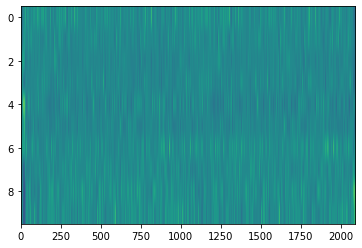

In [7]:
plt.imshow(feature_data, aspect='auto')
feature_data

#**Data Exploration**

Includes a method for stepping through and loading files one at a time, as well as options for various spectro-temporal visualizations.

In [0]:
# Helper function for selecting a wavefile.

def get_next_filename(filenames, mic_place=(["T", "A", "P", "L"])):
    filename = next(filenames)
    if filename.endswith(".wav") & (filename.split('_')[2][0] in mic_place):
        return filename
    else:
        return(get_next_filename(filenames))

filenames = iter(os.listdir(audio_dir))

def get_next_wavfile(filenames, mic_place=(["T", "A", "P", "L"])):
    get_next_filename(filenames, mic_place=mic_place)
    demofile = get_next_filename(filenames)
    x, sr = librosa.load(os.path.join(audio_dir, demofile))

    display(Audio(data=x, rate=sr))
    display(filenames_labels.loc[filenames_labels['filename']==demofile])

    t = np.arange(len(x))/sr
    plt.plot(t, x)
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.title(demofile)
    return x, sr

,filename,has_crackle,has_wheeze
3,160_1b4_Ar_mc_AKGC417L.wav,1,1


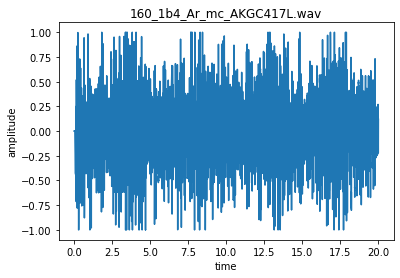

In [0]:
# Load next wav file for analysis.

x, sr = get_next_wavfile(filenames)

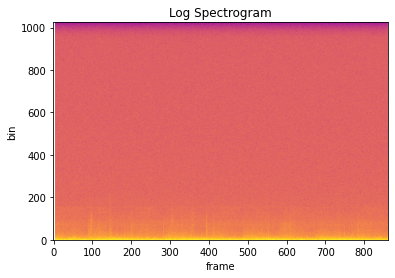

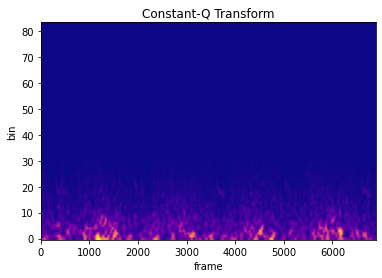

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


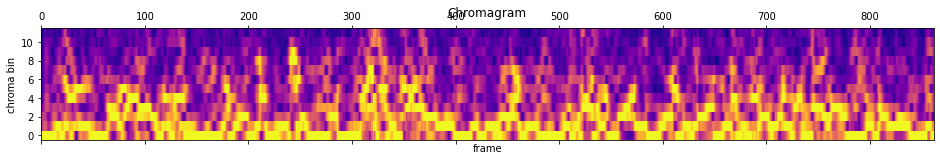

In [0]:
# Visualise with STFT, constant-q transform, and chromagram.

stft_ = librosa.stft(x)
spectrogram = np.log(np.abs(stft_)/np.max(np.abs(stft_)))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap=plt.get_cmap('plasma'))
plt.title('Log Spectrogram')
plt.xlabel('frame')
plt.ylabel('bin')
plt.show()

cqt_ = librosa.cqt(x, hop_length=64)
cqt_ = np.abs(cqt_)
plt.imshow(cqt_, aspect='auto', origin='lower', cmap=plt.get_cmap('plasma'))
plt.title('Constant-Q Transform')
plt.xlabel('frame')
plt.ylabel('bin')
plt.show()

chroma_ = librosa.feature.chroma_cqt(x, sr=sr)
plt.matshow(chroma_, aspect='auto', origin='lower', cmap=plt.get_cmap('plasma'))
plt.title('Chromagram')
plt.xlabel('frame')
plt.ylabel('chroma bin')
plt.show()